In [1]:
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from einops import rearrange
import requests
import io
import json
from functools import reduce
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import mediapy as media
import numpy as np
#from visualization_tools import game_coord_to_pixel_coord

In [2]:
run_dir = Path('session_37f289a3') # Path('baselines/session_ebdfe818')
# original session_e41c9eff, main session_4da05e87, extra session_e1b6d2dc

In [3]:
def path_to_runs(pth):
    tdf = pd.read_csv(pth, compression='gzip')
    return np.array_split(tdf[tdf['map'] != 'map'], 610)

In [4]:
all_runs = [path_to_runs(pth) for pth in tqdm(run_dir.glob('*.gz'))]
all_runs = list(map(list, zip(*all_runs)))

0it [00:00, ?it/s]C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_5476\2235072019.py:2: DtypeWarning: Columns (1,2,3,4,6,7,9,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  tdf = pd.read_csv(pth, compression='gzip')
1it [00:10, 10.39s/it]C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_5476\2235072019.py:2: DtypeWarning: Columns (1,2,3,4,6,7,9,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  tdf = pd.read_csv(pth, compression='gzip')
2it [00:20, 10.49s/it]C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_5476\2235072019.py:2: DtypeWarning: Columns (1,2,3,4,6,7,9,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  tdf = pd.read_csv(pth, compression='gzip')
3it [00:31, 10.50s/it]C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_5476\2235072019.py:2: DtypeWarning: Columns (1,2,3,4,6,7,9,11,12,13,14,15,16) have mixed types. Specify dtype opt

In [5]:
len(all_runs)

610

In [6]:
len(all_runs[0])

8

In [7]:
all_runs[0][0].keys()

Index(['Unnamed: 0', 'step', 'x', 'y', 'map', 'map_location', 'last_action',
       'pcount', 'levels', 'levels_sum', 'ptypes', 'hp', 'frames', 'deaths',
       'badge', 'event', 'healr'],
      dtype='object')

In [8]:
poke_id_to_name = {
    177: "Squirtle",
    255: "None",
    0: "None",
    165: "Rattata",
    36: "Pidgey",
    179: "Wartortle",
    150: "Pidgeotto",
    112: "Weedle",
    113: "Kakuna",
    114: "Beedrill",
    133: "Magikarp",
    169: "Geodude",
    107: "Zubat",
    109: "Paras",
    100: "Jigglypuff",
    84: "Pikachu",
    123: "Caterpie",
    124: "Metapod",
    4: "Clefairy",
    5: "Spearow",
    15: "Nidoran♀"
}
valid_list = [name for name in poke_id_to_name.values() if name != 'None']
valid_list

['Squirtle',
 'Rattata',
 'Pidgey',
 'Wartortle',
 'Pidgeotto',
 'Weedle',
 'Kakuna',
 'Beedrill',
 'Magikarp',
 'Geodude',
 'Zubat',
 'Paras',
 'Jigglypuff',
 'Pikachu',
 'Caterpie',
 'Metapod',
 'Clefairy',
 'Spearow',
 'Nidoran♀']

In [9]:
poke_colors = {
 'Squirtle': (116, 196, 215),
 'Rattata': (157, 134, 162),
 'Pidgey': (190, 157, 119),
 'Wartortle': (80, 156, 214),
 'Pidgeotto': (233, 128, 118),
 'Weedle': (190, 150, 81),
 'Kakuna': (226, 200, 123),
 'Magikarp': (244, 119, 87),
 'Geodude': (176, 176, 176),
 'Zubat': (157, 82, 175),
 'Paras': (241, 171, 100),
 'Jigglypuff': (255, 200, 220),
 'Pikachu': (252, 244, 107),
 'Metapod': (162, 222, 80),
 'Clefairy': (218, 165, 183),
 'Spearow': (163, 75, 71),
 'Nidoran♀': (163, 167, 205),
 'Beedrill': (255,211,109),
 'Caterpie': (125, 206, 104)
}

In [10]:
# count times each pokemon caught
all_poke_counts = []
missing_poke = set()
for run in tqdm(all_runs):
    p_counts = {p:0 for p in valid_list}
    for sim_df in run:
        caught_pokes = set()
        for step in sim_df['ptypes']:
            party = json.loads(step)
            for p in party:
                if p in poke_id_to_name.keys():
                    pname = poke_id_to_name[p]
                    caught_pokes.add(pname)
                elif p not in missing_poke:
                    missing_poke.add(p)
                    print(f'missing poke id: {p}')
        for p in caught_pokes:
            if p == 'None':
                continue
            if p in p_counts.keys():
                p_counts[p] += 1
            else:
                p_counts[p] = 1
    all_poke_counts.append(p_counts)
        

100%|██████████| 610/610 [02:24<00:00,  4.21it/s]


In [11]:
all_poke_counts

[{'Squirtle': 8,
  'Rattata': 6,
  'Pidgey': 1,
  'Wartortle': 0,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 1,
  'Beedrill': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Caterpie': 0,
  'Metapod': 0,
  'Clefairy': 0,
  'Spearow': 0,
  'Nidoran♀': 0},
 {'Squirtle': 8,
  'Rattata': 6,
  'Pidgey': 1,
  'Wartortle': 2,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 1,
  'Beedrill': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Caterpie': 0,
  'Metapod': 0,
  'Clefairy': 0,
  'Spearow': 0,
  'Nidoran♀': 0},
 {'Squirtle': 8,
  'Rattata': 7,
  'Pidgey': 1,
  'Wartortle': 3,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 1,
  'Beedrill': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Caterpie': 0,
  'Metapod': 0,
  'Clefairy': 0,
  'Spearow': 0,
  'Nidoran♀': 0},
 {'Squirtle': 8,
  'Rattata': 8,
  'Pidgey': 1,
  'Wartortle': 0,
 

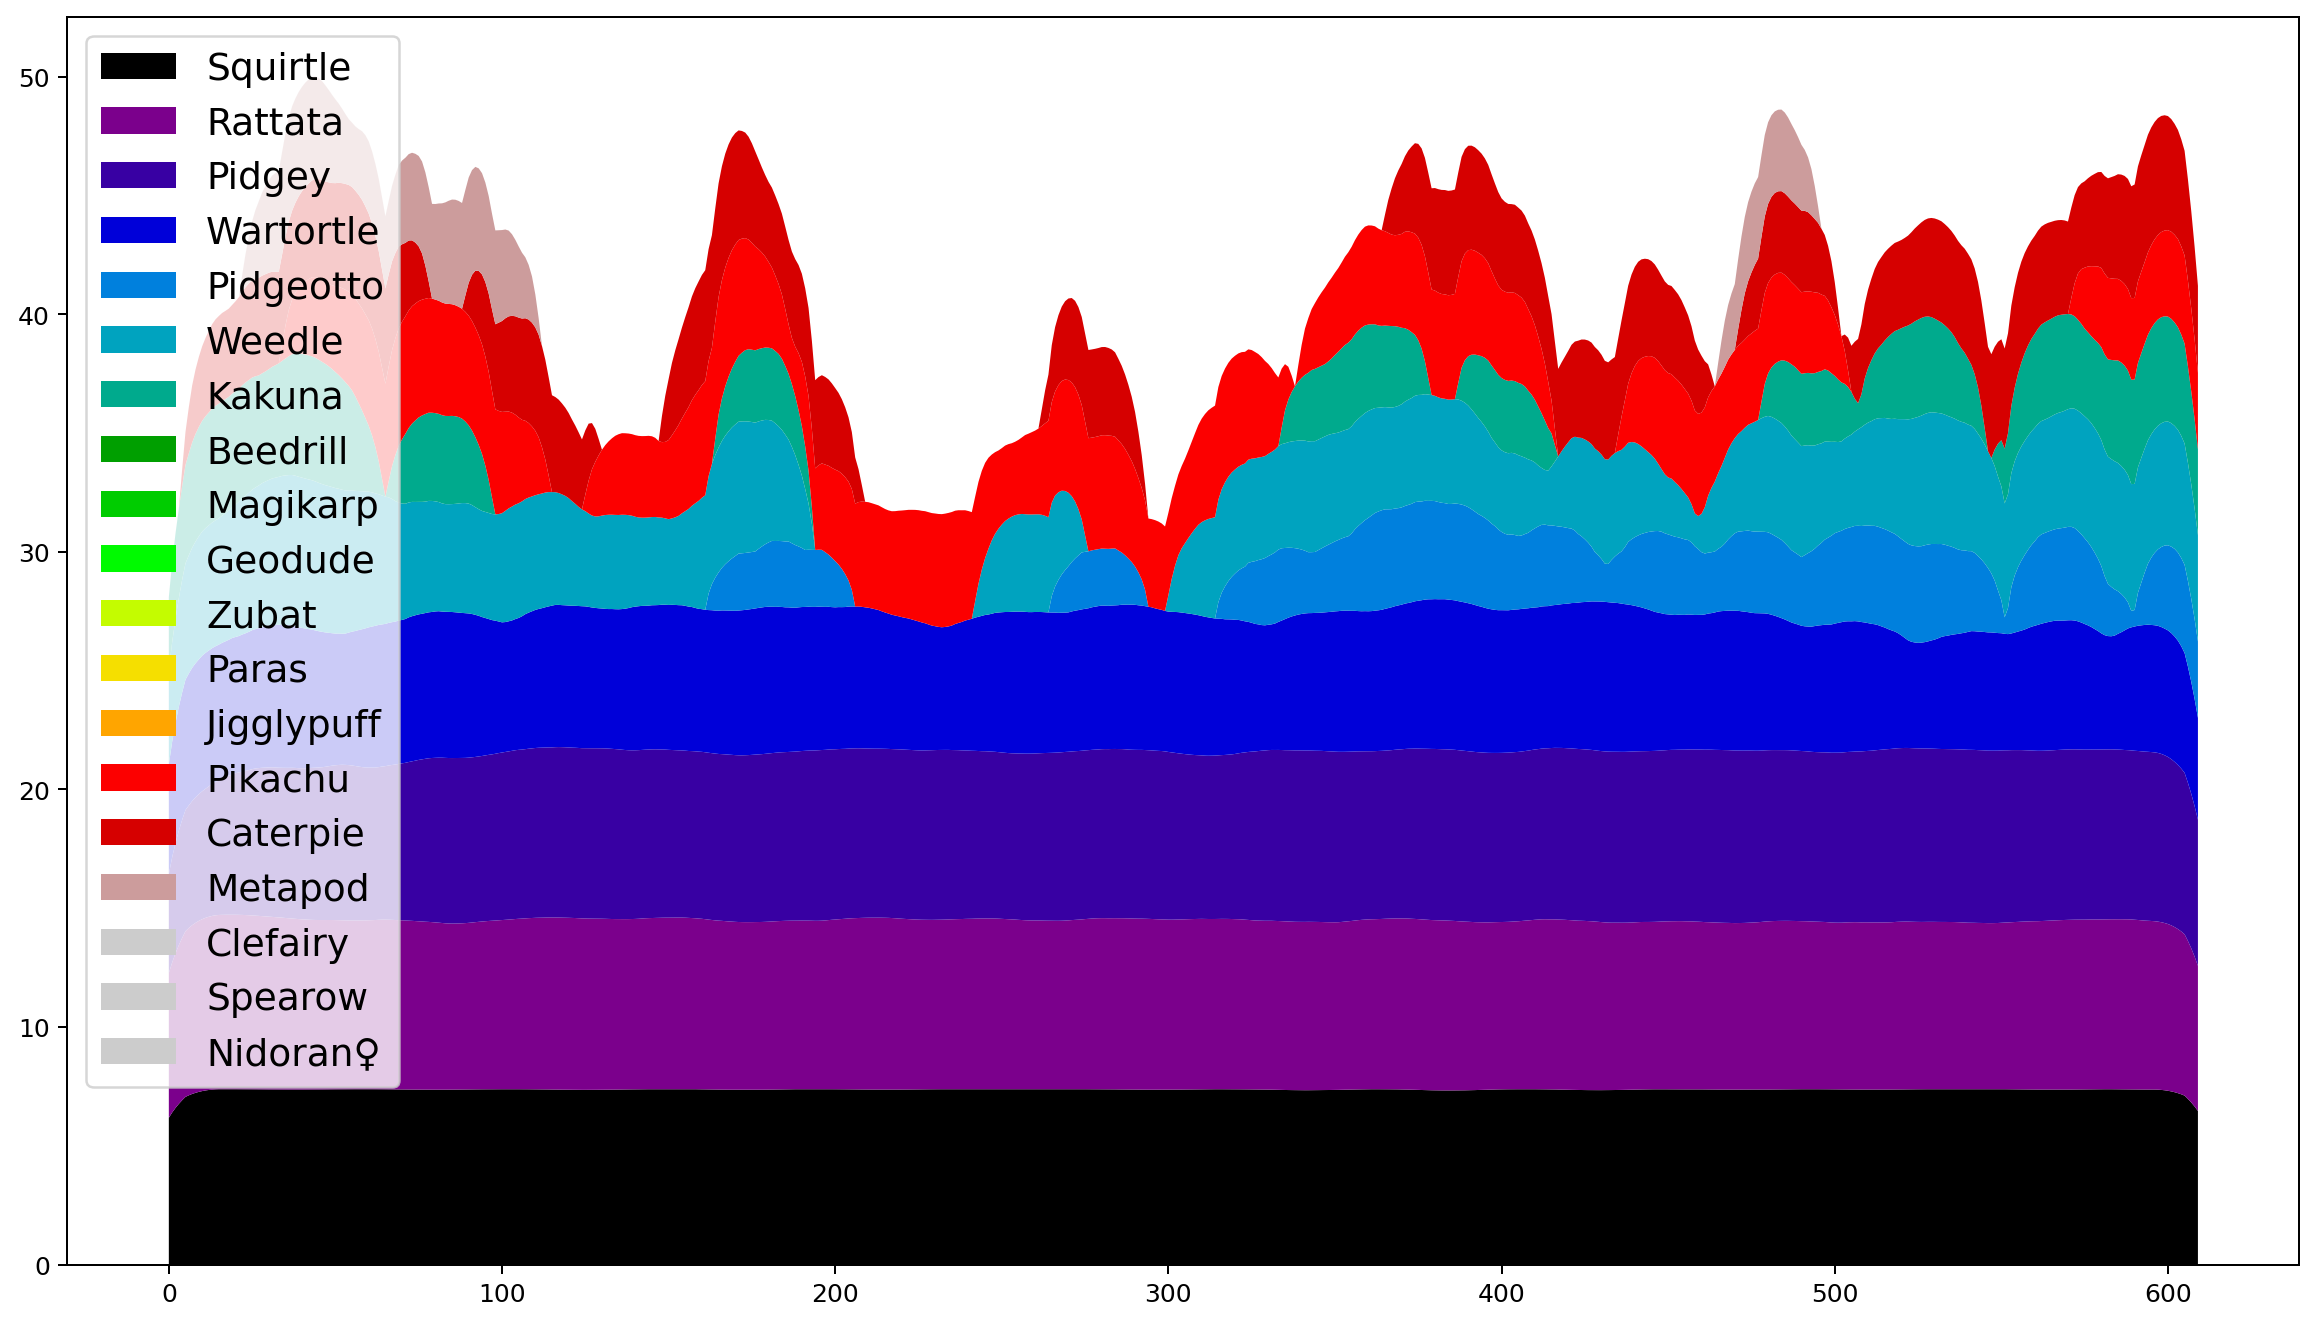

In [12]:
steps = len(all_poke_counts)
x = range(steps)
raw_counts = np.array(list(zip(*[list(counts.values()) for counts in all_poke_counts])))
raw_counts = [np.convolve(rc, np.ones(20), mode='same') for rc in raw_counts]
raw_counts = [np.log(1+np.convolve(rc, np.ones(10), mode='same')) for rc in raw_counts]
plt.figure(figsize=(16, 9), dpi=180)
cols = iter(plt.cm.nipy_spectral(np.linspace(0, 40, steps)))
plt.stackplot(x, *raw_counts, labels=valid_list, colors=cols)
plt.legend(loc='upper left', prop={'size': 15})

In [13]:
base_stats = {
    'pcount': 0, 
    'total_levels': 0, 'frames': 0, 'deaths': 0, 
    'event': 0, 'healr': 0, 'badge': 0
}

In [14]:
# Tìm ra số bước (số hàng) tối đa trong tất cả các dataframe
max_len = 0
for batch in all_runs:
    for run in batch:
        if len(run) > max_len:
            max_len = len(run)

print(f"Độ dài tối đa tìm thấy: {max_len}")

Độ dài tối đa tìm thấy: 6984


In [16]:
def df_to_numpy(df, target_len):
    # load levels and sum
    df['total_levels'] = df['levels'].map(lambda x: sum(json.loads(x)))
    
    # Chuyển đổi sang numpy
    numpy_array = df[base_stats.keys()].applymap(lambda v: float(v)).to_numpy()
    
    # Tạo một mảng đệm bằng số 0
    padded_array = np.zeros((target_len, numpy_array.shape[1]))
    
    # Sao chép dữ liệu từ mảng gốc vào mảng đệm
    padded_array[:numpy_array.shape[0], :] = numpy_array
    
    return padded_array

In [17]:
df_to_numpy(all_runs[0][0], target_len=max_len).shape

(6984, 7)

In [18]:
name_to_idx = {name:idx for idx, name in enumerate(base_stats.keys())}
name_to_idx

{'pcount': 0,
 'total_levels': 1,
 'frames': 2,
 'deaths': 3,
 'event': 4,
 'healr': 5,
 'badge': 6}

In [19]:
# Sử dụng max_len đã tìm được để đệm cho tất cả các mảng có cùng kích thước
big_dat = np.array([[df_to_numpy(run, target_len=max_len) for run in batch] for batch in tqdm(all_runs)])

# Kiểm tra lại shape để chắc chắn
print(f"Shape của big_dat sau khi sửa: {big_dat.shape}")

100%|██████████| 610/610 [03:07<00:00,  3.25it/s]


Shape của big_dat sau khi sửa: (610, 8, 6984, 7)


In [20]:
big_dat.shape

(610, 8, 6984, 7)

In [21]:
big_dat[:,:,:,0].mean(axis=1).shape

(610, 6984)

In [22]:
rearrange(big_dat, '(r x) b s d -> r (x b) s d', x=1).shape

(610, 8, 6984, 7)

In [23]:
the_dat = 'total_levels'
steps = 100
start_step = 130
combine_steps = 5
plot_dat = rearrange(
    big_dat, '(r x) b s d -> r (x b) s d', x=combine_steps
    )[:, :, :, name_to_idx[the_dat]].mean(axis=1)
for i in range(len(plot_dat)):
    plot_dat[i] = gaussian_filter(plot_dat[i], 100.0, mode='nearest')
with media.VideoWriter(f'{the_dat}.mp4', (1080, 1920)) as wr:
    for i in tqdm(np.geomspace(start_step, plot_dat.shape[1]+1, num=steps)):
        i = int(i)
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        for idx, dat in enumerate(plot_dat[:,:i]):
            plt.plot(dat, color=plt.cm.jet(idx/plot_dat.shape[0]))

        # Number of accent colors in the color scheme
        plt.title(the_dat)
        plt.xlabel('game actions', fontsize=14)
        plt.ylabel(the_dat, fontsize=14)

        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        plt.close()

100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


In [24]:
the_dat = 'deaths'
steps = 100
start_step = 20
combine_steps = 10
plot_dat = rearrange(
    big_dat, '(r x) b s d -> r (x b) s d', x=combine_steps
    )[:, :, :, name_to_idx[the_dat]].mean(axis=1)
for i in range(len(plot_dat)):
    plot_dat[i] = gaussian_filter(plot_dat[i], 100.0, mode='nearest')
with media.VideoWriter(f'{the_dat}.mp4', (1080, 1920)) as wr:
    for i in tqdm(np.geomspace(start_step, plot_dat.shape[1]+1, num=steps)):
        i = int(i)
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        for idx, dat in enumerate(plot_dat[:,:i]):
            plt.plot(dat, color=plt.cm.turbo(idx/plot_dat.shape[0]))

        # Number of accent colors in the color scheme
        plt.title(the_dat)
        plt.xlabel('game actions', fontsize=14)
        plt.ylabel(the_dat, fontsize=14)
        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        
        plt.close()

100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


In [25]:
# flipped so we can see progression differently
the_dat = 'total_levels'
steps = 10
start_step = 20
combine_steps = 1
plot_dat = rearrange(
    big_dat, '(r x) b s d -> r (x b) s d', x=combine_steps
    )[:, :, :, name_to_idx[the_dat]].mean(axis=1)
print(plot_dat.shape)
for i in range(len(plot_dat)):
    plot_dat[i] = gaussian_filter(plot_dat[i], 100.0, mode='nearest')
with media.VideoWriter(f'{the_dat}.mp4', (1080, 1920)) as wr:
    for i in tqdm(np.geomspace(start_step, plot_dat.shape[1]+1, num=steps)):
        i = int(i)
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        for idx, dat in enumerate(plot_dat[:,:i]):
            plt.plot(dat, color=plt.cm.turbo(idx/plot_dat.shape[0]))

        # Number of accent colors in the color scheme
        plt.title(the_dat)
        plt.xlabel('game actions', fontsize=14)
        plt.ylabel(the_dat, fontsize=14)
        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        
        plt.close()

(610, 6984)


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


In [26]:
all_poke_counts[0]

{'Squirtle': 8,
 'Rattata': 6,
 'Pidgey': 1,
 'Wartortle': 0,
 'Pidgeotto': 0,
 'Weedle': 0,
 'Kakuna': 1,
 'Beedrill': 0,
 'Magikarp': 0,
 'Geodude': 0,
 'Zubat': 0,
 'Paras': 0,
 'Jigglypuff': 0,
 'Pikachu': 0,
 'Caterpie': 0,
 'Metapod': 0,
 'Clefairy': 0,
 'Spearow': 0,
 'Nidoran♀': 0}

In [27]:
mix_val = 0.1

with media.VideoWriter(f'poke_pie.mp4', (1080, 1920)) as wr:
    vals = {p:0 for p in valid_list}
    for cur_poke in tqdm(all_poke_counts):
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        for name, count in vals.items():
            cc = 0
            if name in cur_poke.keys():
                cc = cur_poke[name]
            vals[name] = count * (1-mix_val) + cc*mix_val
            
        poke_filtered = {name:count for name, count in vals.items() if count > 0}
        explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

        plt.pie(
            poke_filtered.values(), labels=poke_filtered.keys(), 
            colors=[np.array(poke_colors[p])/255 for p in poke_filtered.keys()], autopct='%1.1f%%',
            shadow=False, startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        
        plt.close()

100%|██████████| 610/610 [01:01<00:00,  9.88it/s]


In [28]:
my_df = pd.DataFrame(all_poke_counts).transpose()#.to_csv('cool_poke_data.csv') 
my_df

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
Squirtle,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
Rattata,6,6,7,8,8,8,7,7,8,8,...,5,7,3,3,7,6,6,7,6,6
Pidgey,1,1,1,1,1,2,1,1,1,0,...,6,8,7,7,7,4,4,5,4,5
Wartortle,0,2,3,0,3,5,0,0,2,0,...,0,0,0,1,1,0,1,1,0,0
Pidgeotto,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,0,0
Weedle,0,0,0,2,2,2,1,1,1,0,...,0,0,0,0,1,1,0,4,4,4
Kakuna,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,2,1,1
Beedrill,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Magikarp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Geodude,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
new_df = pd.DataFrame()
mg = 4
for c in range(len(my_df.columns)//mg):
    new_df[c*3] = (my_df[c*mg] + my_df[c*mg+1] + my_df[c*mg+2] + my_df[c*mg+3]) / (mg*5/100)
new_df = new_df.copy()
new_df.to_csv('cool_poke_data.csv') 

C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_5476\1941257315.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[c*3] = (my_df[c*mg] + my_df[c*mg+1] + my_df[c*mg+2] + my_df[c*mg+3]) / (mg*5/100)
C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_5476\1941257315.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[c*3] = (my_df[c*mg] + my_df[c*mg+1] + my_df[c*mg+2] + my_df[c*mg+3]) / (mg*5/100)
C:\Users\H-sky Computer\AppData\Local\Temp\ipykernel_5476\1941257315.py:4: PerformanceWarning: DataFrame is highly

In [30]:
# total pokemon caught!
tot_caught = 0
for run in all_poke_counts:
    for name,count in run.items():
        if name != 'Squirtle':
            tot_caught += count
tot_caught

9124

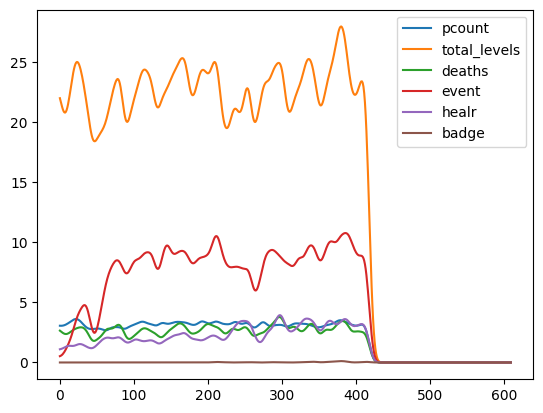

In [31]:
for name in name_to_idx.keys():
    if name == 'frames':
        continue
    plt.plot(
        gaussian_filter(
            big_dat[:, :, -1, name_to_idx[name]].mean(axis=1)
        , 5.0, mode='nearest'),
        label=name
    )
    plt.legend()

In [76]:
# frames gets reset! when level threshold is reached knn index is reset and rews are rebalanced

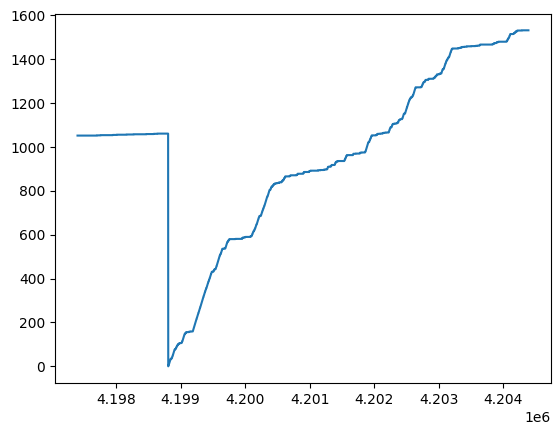

In [32]:
plt.plot(all_runs[601][0]['frames'].map(int))

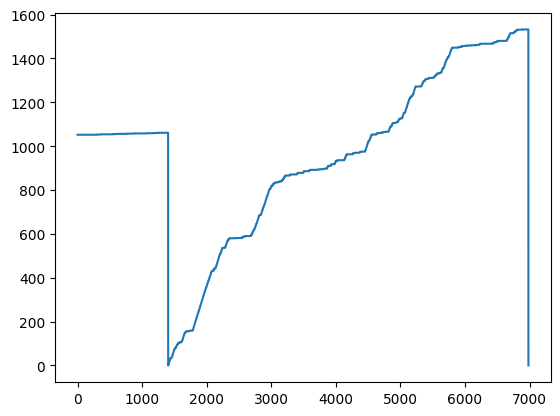

In [33]:
plt.plot(big_dat[601, 0, :, name_to_idx['frames']])

In [34]:
name_to_idx

{'pcount': 0,
 'total_levels': 1,
 'frames': 2,
 'deaths': 3,
 'event': 4,
 'healr': 5,
 'badge': 6}

In [ ]:
!du -h ./* | sort -hr

In [ ]:
!ls session_e41c9eff_start_maybe

In [35]:
with open('session_37f289a3/all_runs_1e7a1480.json') as f:
    stats = json.load(f)

In [36]:
stats

[{'event': 0,
  'level': 92.0,
  'heal': 5.041018142786346,
  'op_lvl': 3.2,
  'dead': -1.6,
  'badge': 0,
  'explore': 161.82},
 {'event': 0,
  'level': 88.0,
  'heal': 11.236871092646918,
  'op_lvl': 0.0,
  'dead': -2.4000000000000004,
  'badge': 0,
  'explore': 115.44},
 {'event': 4,
  'level': 60,
  'heal': 6.58316136515077,
  'op_lvl': 0.0,
  'dead': -2.0,
  'badge': 0,
  'explore': 43.14},
 {'event': 0,
  'level': 28,
  'heal': 8.733623403309526,
  'op_lvl': 0.0,
  'dead': -0.4,
  'badge': 0,
  'explore': 42.059999999999995},
 {'event': 8,
  'level': 90.0,
  'heal': 9.917350931489944,
  'op_lvl': 3.2,
  'dead': -1.6,
  'badge': 0,
  'explore': 182.64},
 {'event': 8,
  'level': 91.0,
  'heal': 11.795410390745484,
  'op_lvl': 3.2,
  'dead': -1.6,
  'badge': 0,
  'explore': 197.88},
 {'event': 0,
  'level': 72,
  'heal': 6.448314303776085,
  'op_lvl': 1.6,
  'dead': -1.6,
  'badge': 0,
  'explore': 58.919999999999995},
 {'event': 8,
  'level': 76,
  'heal': 11.722931043004934,
  'op